In [1]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, SVMSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score


train_encoded = pd.read_csv('train_encoded.csv')
test_encoded = pd.read_csv('test_encoded.csv')

In [2]:
# Check for non-numeric columns in train and test
non_numeric_train = train_encoded.select_dtypes(include=['object', 'category']).columns
non_numeric_test = test_encoded.select_dtypes(include=['object', 'category']).columns

# Combine to see any remaining unique ones
remaining_to_encode = set(non_numeric_train).union(set(non_numeric_test))

print("Remaining columns to encode:", remaining_to_encode)

Remaining columns to encode: set()


In [3]:
import pandas as pd

# Calculate the class distribution
class_distribution = train_encoded['PotentialFraud'].value_counts().reset_index()
class_distribution.columns = ['PotentialFraud', 'Count']

# Calculate the percentage of each class
class_distribution['Percentage'] = (class_distribution['Count'] / class_distribution['Count'].sum()) * 100

# Display the table
print(class_distribution)

   PotentialFraud   Count  Percentage
0               0  345024    61.90859
1               1  212288    38.09141


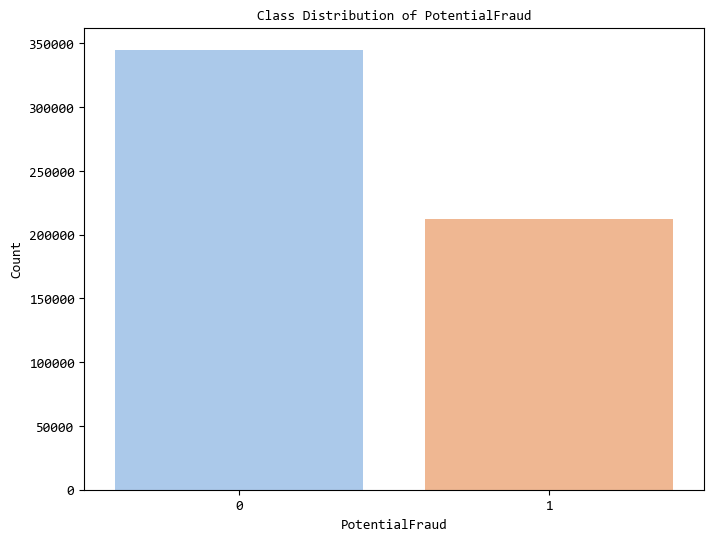

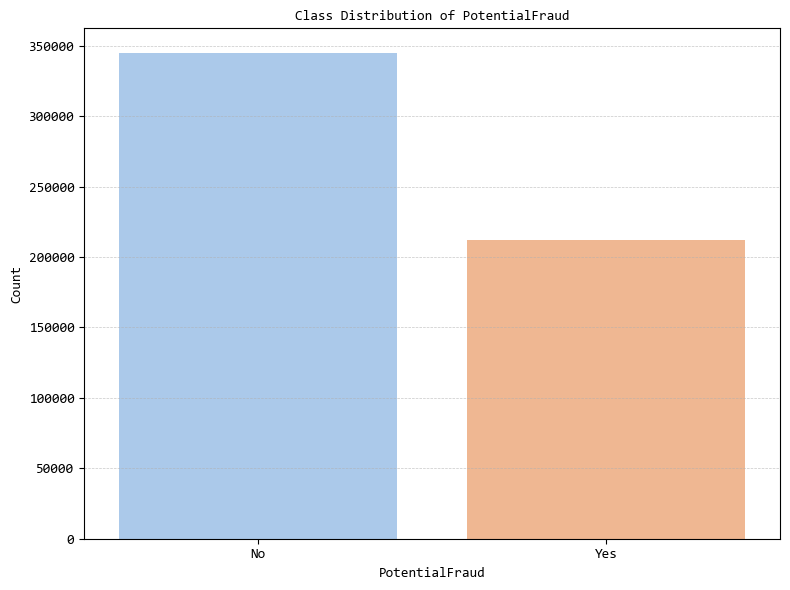

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the class distribution
plt.figure(figsize=(8,6))
sns.countplot(x='PotentialFraud', data=train_encoded, hue='PotentialFraud', palette='pastel', legend=False)
plt.title('Class Distribution of PotentialFraud', fontsize=10, fontname='Consolas')
plt.xlabel('PotentialFraud', fontsize=10, fontname='Consolas')
plt.ylabel('Count', fontsize=10, fontname='Consolas')

# Customize tick parameters
plt.xticks(fontsize=10, fontname='Consolas')
plt.yticks(fontsize=10, fontname='Consolas')

# Show plot
plt.show()



import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='PotentialFraud', data=train_encoded, hue='PotentialFraud', palette='pastel', legend=False)
plt.title('Class Distribution of PotentialFraud', fontsize=10, fontname='Consolas')
plt.xlabel('PotentialFraud', fontsize=10, fontname='Consolas')
plt.ylabel('Count', fontsize=10, fontname='Consolas')

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=10, fontname='Consolas')
plt.yticks(fontsize=10, fontname='Consolas')

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)


plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd

def check_dataset_issues(dataset, dataset_name="Dataset"):
  
    # Check for NaN, Inf, and Negative values in the dataset
    issues = {
        'NaN Values': dataset.isna().sum(),
        'Inf Values': np.isinf(dataset).sum(),
        'Negative Values': (dataset < 0).sum()
    }
    
    # Create a DataFrame of the issues
    issues_df = pd.DataFrame(issues)
    
    # Filter columns with any issues
    issues_df = issues_df[issues_df.sum(axis=1) > 0]
    
    # Transpose for better readability
    issues_df = issues_df.T
    
    # Display the results
    print(f"\n{dataset_name} Issues:")
    display(issues_df)
    return issues_df

In [6]:
# Check issues in train dataset
train_issues = check_dataset_issues(train_encoded, "Train Dataset")


Train Dataset Issues:


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,ReimbursementDeductibleRatio
NaN Values,0,0,18665
Inf Values,0,0,478036
Negative Values,57,15,0


In [7]:
# Check issues in test dataset
test_issues = check_dataset_issues(test_encoded, "Test Dataset")


Test Dataset Issues:


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,ReimbursementDeductibleRatio
NaN Values,0,0,4458
Inf Values,0,0,116253
Negative Values,11,4,0


In [8]:
# Drop 'ReimbursementDeductibleRatio' column from both train and test datasets
train_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)
test_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)

In [9]:
# Define target and features
X = train_encoded.drop(columns='PotentialFraud')
y = train_encoded['PotentialFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Scale the features and ensure the scaled data is a DataFrame with the correct column names
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(verbose=-1),
    'CatBoost': cb.CatBoostClassifier(silent=True),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

print("🔍 Starting model evaluation on original (unbalanced) dataset...\n")

# Evaluate all models with progress bar
for model_name, model in tqdm(models.items(), desc="Models", unit="model"):
    print(f"\n➡️ Training model: {model_name}\n{'='*50}")
    
    # Train and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")

    # Classification report
    print(f"\n📝 Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

print("\n✅ All model evaluations complete.")

🔍 Starting model evaluation on original (unbalanced) dataset...



Models:   0%|          | 0/10 [00:00<?, ?model/s]


➡️ Training model: Logistic Regression


Models:  10%|█         | 1/10 [00:01<00:13,  1.49s/model]

✅ Accuracy: 0.8189

📝 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     69005
           1       0.82      0.67      0.74     42458

    accuracy                           0.82    111463
   macro avg       0.82      0.79      0.80    111463
weighted avg       0.82      0.82      0.81    111463


➡️ Training model: KNN


Models:  20%|██        | 2/10 [02:39<12:30, 93.76s/model]

✅ Accuracy: 0.7247

📝 Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.74      0.86      0.80     69005
           1       0.69      0.50      0.58     42458

    accuracy                           0.72    111463
   macro avg       0.71      0.68      0.69    111463
weighted avg       0.72      0.72      0.71    111463


➡️ Training model: Random Forest


Models:  30%|███       | 3/10 [09:17<27:06, 232.35s/model]

✅ Accuracy: 0.9434

📝 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     69005
           1       0.98      0.87      0.92     42458

    accuracy                           0.94    111463
   macro avg       0.95      0.93      0.94    111463
weighted avg       0.95      0.94      0.94    111463


➡️ Training model: Gradient Boosting


Models:  40%|████      | 4/10 [16:12<30:26, 304.47s/model]

✅ Accuracy: 0.8808

📝 Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     69005
           1       0.96      0.72      0.82     42458

    accuracy                           0.88    111463
   macro avg       0.90      0.85      0.87    111463
weighted avg       0.89      0.88      0.88    111463


➡️ Training model: Naive Bayes


Models:  50%|█████     | 5/10 [16:12<16:14, 194.97s/model]

✅ Accuracy: 0.8071

📝 Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     69005
           1       0.80      0.66      0.72     42458

    accuracy                           0.81    111463
   macro avg       0.81      0.78      0.79    111463
weighted avg       0.81      0.81      0.80    111463


➡️ Training model: XGBoost


Models:  60%|██████    | 6/10 [16:16<08:39, 129.85s/model]

✅ Accuracy: 0.9802

📝 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     69005
           1       0.99      0.95      0.97     42458

    accuracy                           0.98    111463
   macro avg       0.98      0.97      0.98    111463
weighted avg       0.98      0.98      0.98    111463


➡️ Training model: LightGBM


Models:  70%|███████   | 7/10 [16:21<04:26, 88.92s/model] 

✅ Accuracy: 0.9544

📝 Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     69005
           1       0.98      0.90      0.94     42458

    accuracy                           0.95    111463
   macro avg       0.96      0.94      0.95    111463
weighted avg       0.96      0.95      0.95    111463


➡️ Training model: CatBoost


Models:  80%|████████  | 8/10 [17:41<02:52, 86.30s/model]

✅ Accuracy: 0.9958

📝 Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69005
           1       1.00      0.99      0.99     42458

    accuracy                           1.00    111463
   macro avg       1.00      0.99      1.00    111463
weighted avg       1.00      1.00      1.00    111463


➡️ Training model: Decision Tree


Models:  90%|█████████ | 9/10 [18:01<01:05, 65.54s/model]

✅ Accuracy: 0.9930

📝 Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     69005
           1       0.99      0.99      0.99     42458

    accuracy                           0.99    111463
   macro avg       0.99      0.99      0.99    111463
weighted avg       0.99      0.99      0.99    111463


➡️ Training model: AdaBoost


Models: 100%|██████████| 10/10 [19:34<00:00, 117.42s/model]

✅ Accuracy: 0.8372

📝 Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     69005
           1       0.97      0.59      0.73     42458

    accuracy                           0.84    111463
   macro avg       0.88      0.79      0.81    111463
weighted avg       0.86      0.84      0.83    111463


✅ All model evaluations complete.


In [10]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': cb.CatBoostClassifier(silent=True),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

def evaluate_model(X_train, y_train, X_test, y_test, model_name, model):
    print("\n" + "="*60)
    print(f"🔍 Evaluating Model: {model_name}")
    print("="*60)
    
    # Train the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Output
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"📈 ROC AUC Score: {roc_auc:.4f}")
    print(f"\n📝 Classification Report:\n{report}")
    print("="*60)

In [13]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


print("🔍 Starting model evaluation on original (unbalanced) dataset...\n")

# Evaluate all models with progress bar
for model_name, model in tqdm(models.items(), desc="Models", unit="model"):
    print(f"\n➡️ Training model: {model_name}\n{'='*50}")
    
    # Train and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")

    # Classification report
    print(f"\n📝 Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

print("\n✅ All model evaluations complete.")


🔍 Starting model evaluation on original (unbalanced) dataset...



Models:   0%|          | 0/10 [00:00<?, ?model/s]


➡️ Training model: Logistic Regression


Models:  10%|█         | 1/10 [00:01<00:13,  1.54s/model]

✅ Accuracy: 0.8189

📝 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     69005
           1       0.82      0.67      0.74     42458

    accuracy                           0.82    111463
   macro avg       0.82      0.79      0.80    111463
weighted avg       0.82      0.82      0.81    111463


➡️ Training model: KNN


Models:  20%|██        | 2/10 [02:52<13:28, 101.10s/model]

✅ Accuracy: 0.7247

📝 Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.74      0.86      0.80     69005
           1       0.69      0.50      0.58     42458

    accuracy                           0.72    111463
   macro avg       0.71      0.68      0.69    111463
weighted avg       0.72      0.72      0.71    111463


➡️ Training model: Random Forest


Models:  30%|███       | 3/10 [07:15<20:27, 175.30s/model]

✅ Accuracy: 0.9430

📝 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     69005
           1       0.98      0.87      0.92     42458

    accuracy                           0.94    111463
   macro avg       0.95      0.93      0.94    111463
weighted avg       0.95      0.94      0.94    111463


➡️ Training model: Gradient Boosting


Models:  40%|████      | 4/10 [12:17<22:29, 224.98s/model]

✅ Accuracy: 0.8808

📝 Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     69005
           1       0.96      0.72      0.82     42458

    accuracy                           0.88    111463
   macro avg       0.90      0.85      0.87    111463
weighted avg       0.89      0.88      0.88    111463


➡️ Training model: Naive Bayes


Models:  50%|█████     | 5/10 [12:17<12:00, 144.10s/model]

✅ Accuracy: 0.8071

📝 Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.81      0.90      0.85     69005
           1       0.80      0.66      0.72     42458

    accuracy                           0.81    111463
   macro avg       0.81      0.78      0.79    111463
weighted avg       0.81      0.81      0.80    111463


➡️ Training model: XGBoost


Models:  60%|██████    | 6/10 [12:25<06:30, 97.63s/model] 

✅ Accuracy: 0.9802

📝 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     69005
           1       0.99      0.95      0.97     42458

    accuracy                           0.98    111463
   macro avg       0.98      0.97      0.98    111463
weighted avg       0.98      0.98      0.98    111463


➡️ Training model: LightGBM
[LightGBM] [Info] Number of positive: 169830, number of negative: 276019
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5027
[LightGBM] [Info] Number of data points in the train set: 445849, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.380914 -> initscore=-0.485672
[LightGBM] [Info] Start training from score -0.485672


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Models:  70%|███████   | 7/10 [12:33<03:24, 68.27s/model]

✅ Accuracy: 0.9544

📝 Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     69005
           1       0.98      0.90      0.94     42458

    accuracy                           0.95    111463
   macro avg       0.96      0.94      0.95    111463
weighted avg       0.96      0.95      0.95    111463


➡️ Training model: CatBoost


Models:  80%|████████  | 8/10 [14:54<03:03, 91.64s/model]

✅ Accuracy: 0.9958

📝 Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69005
           1       1.00      0.99      0.99     42458

    accuracy                           1.00    111463
   macro avg       1.00      0.99      1.00    111463
weighted avg       1.00      1.00      1.00    111463


➡️ Training model: Decision Tree


Models:  90%|█████████ | 9/10 [15:08<01:07, 67.27s/model]

✅ Accuracy: 0.9929

📝 Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     69005
           1       0.99      0.99      0.99     42458

    accuracy                           0.99    111463
   macro avg       0.99      0.99      0.99    111463
weighted avg       0.99      0.99      0.99    111463


➡️ Training model: AdaBoost


Models: 100%|██████████| 10/10 [16:16<00:00, 97.67s/model]

✅ Accuracy: 0.8372

📝 Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     69005
           1       0.97      0.59      0.73     42458

    accuracy                           0.84    111463
   macro avg       0.88      0.79      0.81    111463
weighted avg       0.86      0.84      0.83    111463


✅ All model evaluations complete.
